In [28]:
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# 1) Load precomputed features
train_data = np.load("train_features_augmented.npz", allow_pickle=True)
X_train, y_train = train_data["data"], train_data["labels"]

val_data = np.load("val_features.npz", allow_pickle=True)
X_val, y_val = val_data["data"], val_data["labels"]

# 2) Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_train_oh = to_categorical(y_train_enc)
y_val_oh = to_categorical(y_val_enc)
joblib.dump(le, "label_encoder.pkl")

# 3) Preprocess features
max_val = np.max(np.abs(X_train))
X_train = X_train / max_val
X_val = X_val / max_val

# Reshape from (40, 130, 3) to (130, 120) → 130 time steps, 120 features
X_train = X_train.reshape(X_train.shape[0], 130, 120)
X_val = X_val.reshape(X_val.shape[0], 130, 120)

# 4) Compute class weights
class_ids = np.argmax(y_train_oh, axis=1)
weights = compute_class_weight("balanced", classes=np.unique(class_ids), y=class_ids)
class_weight = dict(enumerate(weights))

# 5) Build CNN + BiLSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(130, 120)),

    Conv1D(64, kernel_size=5, activation='relu',kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu',kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),  # New layer
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),  # Extra Conv layer to replace BiLSTM
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    
    Flatten(),
    Dense(8, activation='softmax')
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 6) Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=0.5, verbose=1)

# 7) Train
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=60,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early_stop, lr_reduce]
)

# 8) Save model
model.save("cnn_emotion_model.h5")

# 9) Evaluate0.7434 
val_loss, val_acc = model.evaluate(X_val, y_val_oh)
print(f"\nCNN Validation Accuracy: {val_acc:.4f}")


Epoch 1/60
246/246 [==============================] - 16s 45ms/step - loss: 2.4450 - accuracy: 0.2477 - val_loss: 2.7546 - val_accuracy: 0.0794 - lr: 0.0010
Epoch 2/60
246/246 [==============================] - 10s 40ms/step - loss: 1.8897 - accuracy: 0.3928 - val_loss: 2.3940 - val_accuracy: 0.2892 - lr: 0.0010
Epoch 3/60
246/246 [==============================] - 9s 37ms/step - loss: 1.6366 - accuracy: 0.4897 - val_loss: 1.5317 - val_accuracy: 0.5153 - lr: 0.0010
Epoch 4/60
246/246 [==============================] - 9s 37ms/step - loss: 1.4964 - accuracy: 0.5240 - val_loss: 1.2524 - val_accuracy: 0.6253 - lr: 0.0010
Epoch 5/60
246/246 [==============================] - 10s 39ms/step - loss: 1.3785 - accuracy: 0.5617 - val_loss: 1.3605 - val_accuracy: 0.5662 - lr: 0.0010
Epoch 6/60
246/246 [==============================] - 10s 41ms/step - loss: 1.3146 - accuracy: 0.5864 - val_loss: 1.2416 - val_accuracy: 0.5988 - lr: 0.0010
Epoch 7/60
245/246 [============================>.] - ETA: 0

 1/16 [>.............................] - ETA: 0s - loss: 0.6300 - accuracy: 0.9062

C:\Users\lenovo 6pin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 11ms/step - loss: 0.8575 - accuracy: 0.7739

CNN Validation Accuracy: 0.7739


In [29]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import numpy as np

# Get predicted probabilities and convert to class indices
y_pred_prob = model.predict(X_val)
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_val_oh, axis=1)

# Overall Accuracy
val_acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"\nValidation Accuracy: {val_acc:.4f}")

# Weighted F1 Score
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

# Per-Class Accuracy
cm = confusion_matrix(y_true_labels, y_pred_labels)
class_wise_acc = cm.diagonal() / cm.sum(axis=1)

print("\nPer-Class Accuracy:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {class_wise_acc[i]:.4f}")


16/16 [==============================] - 1s 11ms/step

Validation Accuracy: 0.7739
Weighted F1 Score: 0.7733

Classification Report:
              precision    recall  f1-score   support

       angry       0.86      0.87      0.86        75
        calm       0.86      0.79      0.82        75
     disgust       0.76      0.72      0.74        39
     fearful       0.70      0.77      0.73        75
       happy       0.77      0.81      0.79        75
     neutral       0.74      0.84      0.79        38
         sad       0.75      0.64      0.69        75
   surprised       0.72      0.74      0.73        39

    accuracy                           0.77       491
   macro avg       0.77      0.77      0.77       491
weighted avg       0.78      0.77      0.77       491


Per-Class Accuracy:
angry: 0.8667
calm: 0.7867
disgust: 0.7179
fearful: 0.7733
happy: 0.8133
neutral: 0.8421
sad: 0.6400
surprised: 0.7436


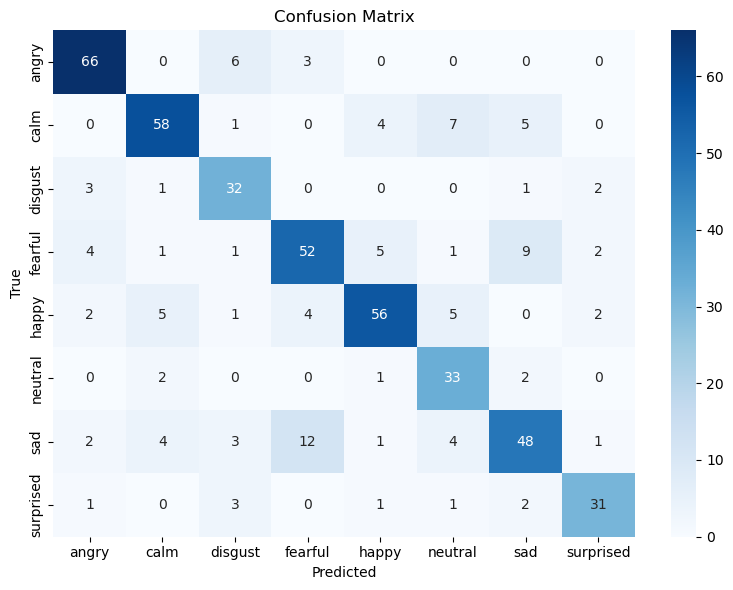

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

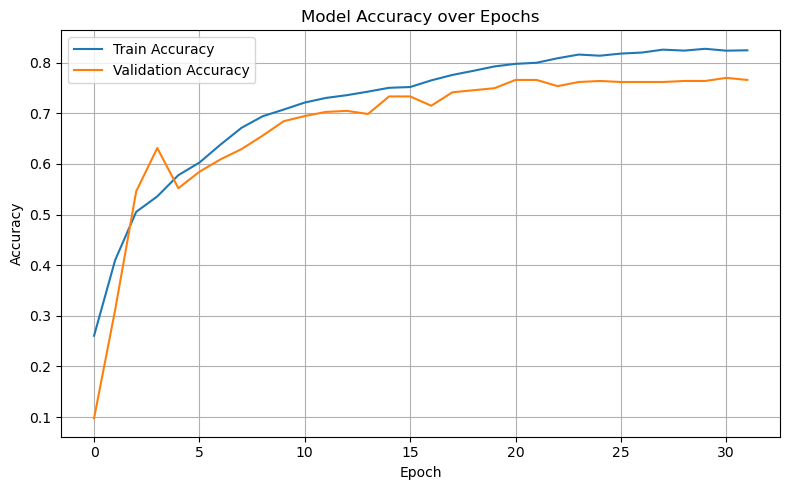

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

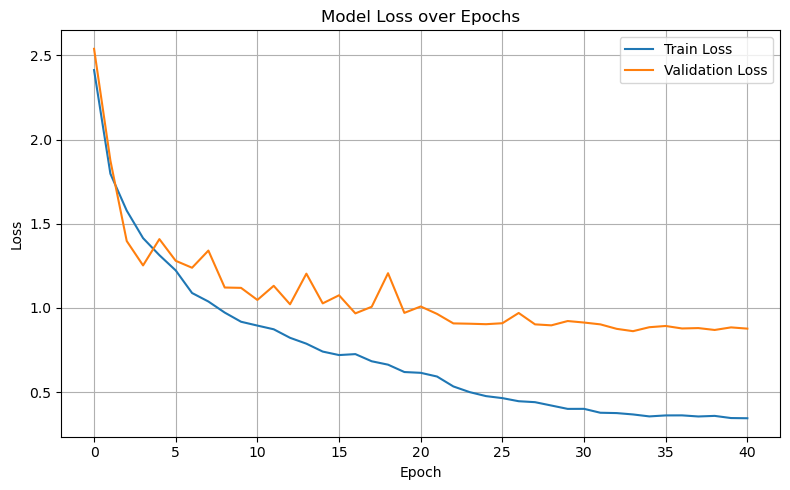

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
